# RESEARCH QUESTION: How to predict the ghg Score of a vehicle? 

This rating reflects vehicle tailpipe emissions of carbon dioxide (CO2), the most prevalent greenhouse gas (GHG). CO2 emissions typically constitute 99% of the tailpipe emissions of greenhouse gases. 

https://www.epa.gov/greenvehicles/greenhouse-gas-rating for further information

## Packages used 

In [1]:
# base modules
import os
import sys
import copy
import logging

# for manipulating data
import numpy as np
import pandas as pd
import dill
import math
from sklearn.model_selection import train_test_split

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# for visualization
from IPython.display import display
from matplotlib import pyplot as plt
import seaborn as sns
!pip install --upgrade rulefit shap

In [2]:
path_to_repo = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
path_to_repo

'/Users/filippoceccarani/Desktop/EMLyon-ML-course-2022-T1'

In [3]:
sys.path.insert(0, os.path.join(path_to_repo, 'src'))

In [4]:
from emlyon.utils import *

## The datasets 

We found our database on US Department of Energy website (https://www.fueleconomy.gov/feg/ws/). Which is the official US government source for fuel economy information. 

We have two datasets: one regarding the vehicles information and the other the respective emissions. 
We need to merge them. 

The dataframes has the same id column, so we are merging the 2 dataframe based on that. 

In [5]:
#open the emissions dataframe dfe

dfe = pd.read_csv('emissions.csv')

In [6]:
np.random.seed(42)

The emissison dataframe has 8 columns of dtypes: float64(2), int64(3), object(3), and 44979 rows

In [7]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44979 entries, 0 to 44978
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   efid           44979 non-null  object 
 1   id             44979 non-null  int64  
 2   salesArea      44979 non-null  int64  
 3   score          44979 non-null  float64
 4   scoreAlt       44979 non-null  float64
 5   smartwayScore  44979 non-null  int64  
 6   standard       44979 non-null  object 
 7   stdText        44965 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 2.7+ MB


In [8]:
#open the vehicles dataframe dfv

dfv = pd.read_csv('vehicles.csv')

/var/folders/x7/tm9d29mx1lv2zl6slvnz5xvw0000gn/T/ipykernel_17497/3739757489.py:3: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  dfv = pd.read_csv('vehicles.csv')


The vehicles dataframe has 83 columns of dtypes: bool(1), float64(32), int64(27), object(23), and 44768 rows

In [9]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44787 entries, 0 to 44786
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   barrels08        44787 non-null  float64
 1   barrelsA08       44787 non-null  float64
 2   charge120        44787 non-null  float64
 3   charge240        44787 non-null  float64
 4   city08           44787 non-null  int64  
 5   city08U          44787 non-null  float64
 6   cityA08          44787 non-null  int64  
 7   cityA08U         44787 non-null  float64
 8   cityCD           44787 non-null  float64
 9   cityE            44787 non-null  float64
 10  cityUF           44787 non-null  float64
 11  co2              44787 non-null  int64  
 12  co2A             44787 non-null  int64  
 13  co2TailpipeAGpm  44787 non-null  float64
 14  co2TailpipeGpm   44787 non-null  float64
 15  comb08           44787 non-null  int64  
 16  comb08U          44787 non-null  float64
 17  combA08     

In [10]:
# Eliminated all the id duplicate for the dataframe "emission"

dfe = dfe.sort_values('id', ascending=False)
dfe = dfe.drop_duplicates(subset='id', keep='first')

In [11]:
# Eliminated all the id duplicate for the dataframe "vehicles"

dfv = dfv.sort_values('id', ascending=False)
dfv = dfv.drop_duplicates(subset='id', keep='first')

In [12]:
#Merge the two datasets 

df_raw = pd.merge(left=dfe, right=dfv, left_on='id', right_on='id')

## Descriptive statistics

Check the shape and the values in each column. 

In [13]:
#shape of the new dataframe

df_raw.shape

(21950, 90)

In [14]:
df_raw.describe()

,id,salesArea,score,scoreAlt,smartwayScore,barrels08,barrelsA08,charge120,charge240,city08,...,UCity,UCityA,UHighway,UHighwayA,year,youSaveSpend,charge240b,phevCity,phevHwy,phevComb
count,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.0,21950.000000,21950.000000,...,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000,21950.000000
mean,32950.602961,5.353121,5.033075,-0.925194,-0.578132,14.322039,0.338052,0.0,0.168935,20.527335,...,26.277834,2.082464,38.250700,1.591420,2013.437585,-4824.054670,0.032768,0.513075,0.514806,0.511617
std,7622.982502,2.165905,1.929742,0.651950,0.857135,4.048618,1.280617,0.0,1.202342,12.221939,...,17.467813,12.530751,15.057325,7.435685,5.431032,4807.963642,0.468504,5.231607,5.032342,5.108823
min,19332.000000,1.000000,-12.000000,-1.000000,-1.000000,0.047081,0.000000,0.0,0.000000,8.000000,...,9.300000,0.000000,15.100000,0.000000,2004.000000,-29500.000000,0.000000,0.000000,0.000000,0.000000
25%,25431.500000,3.000000,5.000000,-1.000000,-1.000000,11.900400,0.000000,0.0,0.000000,16.000000,...,19.300000,0.000000,30.500000,0.000000,2009.000000,-7750.000000,0.000000,0.000000,0.000000,0.000000
50%,33824.500000,7.000000,5.000000,-1.000000,-1.000000,14.167143,0.000000,0.0,0.000000,18.000000,...,23.100000,0.000000,35.980550,0.000000,2014.000000,-4250.000000,0.000000,0.000000,0.000000,0.000000
75%,39443.750000,7.000000,6.000000,-1.000000,-1.000000,16.528333,0.000000,0.0,0.000000,22.000000,...,28.000000,0.000000,42.378500,0.000000,2018.000000,-1750.000000,0.000000,0.000000,0.000000,0.000000
max,45092.000000,9.000000,10.000000,6.000000,2.000000,33.056667,16.528333,0.0,15.300000,150.000000,...,224.800000,207.262200,187.100000,173.143600,2022.000000,9750.000000,9.600000,97.000000,81.000000,88.000000


In [15]:
df_raw["ghgScore"].value_counts()

-1     9444
 5     3185
 4     2516
 6     1665
 3     1624
 7     1265
 2      653
 8      604
 10     540
 1      259
 9      195
Name: ghgScore, dtype: int64

# Data Inspection

As the dataset is very technical and has a lot of column, in the data inspection we are trying to understand the relevance of each column and which one to delete. 

#### GENERAL CHARACTERISTICS: 
'make': manufacturer brand <br> 
'model': model name <br> 
'year': production year, from 2009-2018 <br> 

#### ENGINE CHARACTERISTICS: 
'fuelType' <br>
'cylinders': engine cylinders <br>
'displ': engine displacement in liters<br>
'eng_dscr': <br> 
'phevBlended: if true, this vehicle operates on a blend of gasoline and electricity in charge depleting mode'<br>
'atvType': type of alternative fuel or advanced technology vehicle <br>

#### POLLUTION: 
'co2TailpipeAGpm', 'co2TailpipeGpm' <br>
'co2', 'co2A'<br>
'ghgScore' <br>
'ghgScoreA' <br>

#### DRIVETRAIN: 
'drive': <br>
'trany': <br>
'trans_dscr',<br>

#### CHASSIS: 
'VClass': EPA vehicle size class <br>
'pv2': 2-door passenger volume <br>
'pv4': 4-door passenger volume <br>
'lv2': 2 door luggage volume (cubic feet) <br>
'lv4': 4 door luggage volume (cubic feet) <br>
'hlv': hatchback luggage volume (cubic feet) <br>
'hpv': hatchback passenger volume (cubic feet) <br>

#### ELECTRONICS: 
'tCharger':
'sCharger': 
'startStop': 

#### FUEL CONSUMPTION: 
'city08': city MPG for fuelType1 and 2 <br>
'highway08': highway MPG for fuelType1 and 2 <br>



### Columns to be deleted:
#### All the different variable that distinuish between fuelType1 and fuelType2 can be summed up
'fuelType1': For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this will be the conventional fuel.<br>
'fuelType2': For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG). For single fuel vehicles, this field is not used

'barrels08', 'barrelsA08': annual petroleum consumption in barrels<br>
'fuelCost08', 'fuelCostA08'<br>
'comb08',  'combA08'<br>
'city08', 'cityA08'<br>
'highway08', 'highwayA08'<br>
'city08U', 'cityA08U': unrounded city MPG for fuelType1 <br> 
'highway08U', 'highwayA08U'<br>
'highwayCD','highwayE','highwayUF' <br>
'combinedCD','combE','combinedUF' <br>
'standard'<br>
'stdText'<br>
'trans_dscr'<br>
'efid',<br>
'id'<br>


### Columns to be deleted becasue not relevant for the research:
'createdOn' - date the vehicle record was created (ISO 8601 format)<br>
'modifiedOn' - date the vehicle record was last modified (ISO 8601 format)<br>
'salesArea' - The area of the country where the vehicle can legally be sold.<br>
'youSaveSpend' - you save/spend over 5 years compared to an average car <br>
'guzzler' - if G or T, this vehicle is subject to the gas guzzler tax <br>
'c240Dscr' - electric vehicle charger description <br>
'charge240b' - time to charge an electric vehicle in hours at 240 V using the alternate charger <br> 
'c240bDscr' - <br>
'mfrCode' - 3-character manufacturer code <br>
'mpgData' - has My MPG data <br>
'phevBlended'  <br>
'range', 'rangeA', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA' - <br>
'score', 'scoreAlt' - <br>
'UCity', 'UCityA', 'UHighway', 'UHighwayA'- <br>
'phevCity', 'phevHwy', 'phevComb' - <br>
'smartwayScore' - <br>
'charge120' - time to charge an electric vehicle in hours at 120 V <br>
'charge240' - time to charge an electric vehicle in hours at 240 V <br>
'evMotor' - <br>
'feScore' - <br>

In [16]:
#show all columns indeces 
df_raw.columns

Index(['efid', 'id', 'salesArea', 'score', 'scoreAlt', 'smartwayScore',
       'standard', 'stdText', 'barrels08', 'barrelsA08', 'charge120',
       'charge240', 'city08', 'city08U', 'cityA08', 'cityA08U', 'cityCD',
       'cityE', 'cityUF', 'co2', 'co2A', 'co2TailpipeAGpm', 'co2TailpipeGpm',
       'comb08', 'comb08U', 'combA08', 'combA08U', 'combE', 'combinedCD',
       'combinedUF', 'cylinders', 'displ', 'drive', 'engId', 'eng_dscr',
       'feScore', 'fuelCost08', 'fuelCostA08', 'fuelType', 'fuelType1',
       'ghgScore', 'ghgScoreA', 'highway08', 'highway08U', 'highwayA08',
       'highwayA08U', 'highwayCD', 'highwayE', 'highwayUF', 'hlv', 'hpv',
       'lv2', 'lv4', 'make', 'model', 'mpgData', 'phevBlended', 'pv2', 'pv4',
       'range', 'rangeCity', 'rangeCityA', 'rangeHwy', 'rangeHwyA', 'trany',
       'UCity', 'UCityA', 'UHighway', 'UHighwayA', 'VClass', 'year',
       'youSaveSpend', 'guzzler', 'trans_dscr', 'tCharger', 'sCharger',
       'atvType', 'fuelType2', 'rangeA', 'ev

In [17]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [18]:
display_all(df_raw.describe(include = 'all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
efid,21950,6529,GPRXV04.0C91,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,21950.0,NaN,NaN,NaN,32950.602961,7622.982502,19332.0,25431.5,33824.5,39443.75,45092.0
salesArea,21950.0,NaN,NaN,NaN,5.353121,2.165905,1.0,3.0,7.0,7.0,9.0
score,21950.0,NaN,NaN,NaN,5.033075,1.929742,-12.0,5.0,5.0,6.0,10.0
scoreAlt,21950.0,NaN,NaN,NaN,-0.925194,0.65195,-1.0,-1.0,-1.0,-1.0,6.0
smartwayScore,21950.0,NaN,NaN,NaN,-0.578132,0.857135,-1.0,-1.0,-1.0,-1.0,2.0
standard,21950,48,U2,4066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stdText,21941,64,LEV-II ULEV,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
barrels08,21950.0,NaN,NaN,NaN,14.322039,4.048618,0.047081,11.9004,14.167143,16.528333,33.056667
barrelsA08,21950.0,NaN,NaN,NaN,0.338052,1.280617,0.0,0.0,0.0,0.0,16.528333


In [19]:
#fuelType = fuelType1 + fuelType2 
#fuelType can be deleted 

df_raw["fuelType"].value_counts()

Regular                        10338
Premium                         9223
Gasoline or E85                 1188
Diesel                           346
Electricity                      323
Midgrade                         138
Premium and Electricity          122
Premium or E85                   115
Regular Gas and Electricity       76
Premium Gas or Electricity        53
CNG                               20
Regular Gas or Electricity         4
Gasoline or natural gas            4
Name: fuelType, dtype: int64

In [20]:
#For single fuel vehicles, this will be the only fuel. For dual fuel vehicles, this will be the conventional fuel.
df_raw["fuelType1"].value_counts()

Regular Gasoline     11610
Premium Gasoline      9513
Diesel                 346
Electricity            323
Midgrade Gasoline      138
Natural Gas             20
Name: fuelType1, dtype: int64

In [21]:
df_raw["make"].value_counts()

Chevrolet        1746
BMW              1620
Ford             1449
Mercedes-Benz    1224
Toyota           1065
                 ... 
Rivian              2
Fisker              1
Mahindra            1
Shelby              1
Kandi               1
Name: make, Length: 76, dtype: int64

In [22]:
df_raw["model"].value_counts()

Jetta                    105
Mustang                   98
Camaro                    92
Accord                    78
Tacoma 4WD                65
                        ... 
Titan 4WD PRO-4X           1
RAV4 Hybrid  AWD           1
RS4 Cabriolet              1
AMG GLS63 4matic Plus      1
I-Pace EV400               1
Name: model, Length: 3146, dtype: int64

In [23]:
df_raw["year"].value_counts()

2018    1340
2019    1315
2017    1281
2021    1275
2015    1268
2016    1246
2020    1245
2014    1213
2013    1170
2022    1153
2008    1129
2012    1120
2010    1071
2011    1065
2006    1056
2005    1048
2004    1040
2007     992
2009     923
Name: year, dtype: int64

In [24]:
df_raw["cylinders"].value_counts()

4.0     8143
6.0     7521
8.0     4640
12.0     488
5.0      440
3.0      194
10.0     156
2.0       28
16.0      17
Name: cylinders, dtype: int64

In [25]:
df_raw["displ"].value_counts()

2.0    3264
3.0    2149
3.5    1678
2.5    1378
2.4    1242
       ... 
0.9       6
8.3       6
2.1       5
5.8       2
0.0       1
Name: displ, Length: 62, dtype: int64

In [26]:
df_raw["phevBlended"].value_counts()

False    21752
True       198
Name: phevBlended, dtype: int64

In [27]:
df_raw["drive"].value_counts()

Front-Wheel Drive             6879
Rear-Wheel Drive              6545
All-Wheel Drive               4154
4-Wheel or All-Wheel Drive    2040
4-Wheel Drive                 1942
Part-time 4-Wheel Drive        390
Name: drive, dtype: int64

In [28]:
df_raw["atvType"].value_counts()

FFV               1303
Hybrid             906
Diesel             346
EV                 323
Plug-in Hybrid     255
CNG                 20
Bifuel (CNG)         4
Name: atvType, dtype: int64

In [29]:
df_raw["eng_dscr"].isnull().sum()

11165

In [30]:
df_raw["trans_dscr"].value_counts()

CLKUP              2521
2MODE CLKUP         555
3MODE CLKUP         414
EMS 2MODE CLKUP     293
SIL                 149
EMS                 129
CMODE               115
3MODE                80
2MODE                71
VMODE CLKUP          50
CMODE CLKUP          47
DC/FW                44
6MODE CLKUP          31
4MODE                28
2MODE 2LKUP          27
EMS CLKUP            24
VMODE VLKUP          24
VLKUP                21
CMODE VLKUP          14
SIL EMS               7
6MODE                 6
4MODE CLKUP           6
SIL 2MODE CLKUP       4
SIL 3MODE             3
3MODE VLKUP           2
LONG RATIO            2
EMS 3MODE CLKUP       2
3MODE CLKUP FW        1
SIL 3MODE CLKUP       1
Name: trans_dscr, dtype: int64

In [31]:
#For dual fuel vehicles, this will be the alternative fuel (e.g. E85, Electricity, CNG, LPG).
df_raw["fuelType2"].value_counts()

E85            1303
Electricity     255
Natural Gas       4
Name: fuelType2, dtype: int64

In [32]:
#the empty value mean the vehicle only have one type of fuel 
df_raw['fuelType2'].isna().sum()

20388

In [33]:
#electric vehicle charger description
df_raw["c240Dscr"].value_counts()

standard charger    116
3.6 kW charger        4
single charger        3
7.2 kW charger        2
6.6 kW charger        2
Name: c240Dscr, dtype: int64

In [34]:
#time to charge an electric vehicle in hours at 240 V using the alternate charger
df_raw["charge240b"].value_counts()

0.00    21833
4.75       46
8.00       18
8.50       15
3.75        9
8.30        5
6.20        4
9.60        4
5.00        3
8.20        2
4.40        2
6.60        2
6.50        1
5.80        1
9.30        1
2.30        1
7.00        1
2.50        1
4.00        1
Name: charge240b, dtype: int64

In [35]:
df_raw["city08"].value_counts()

18     1956
17     1953
16     1911
19     1731
15     1702
       ... 
61        1
93        1
60        1
67        1
148       1
Name: city08, Length: 124, dtype: int64

In [36]:
#the fuel consumption in the city for fuelType2 is mainly 0 - therefore we are adding up the column 'city08' and 'cityA08'
df_raw["city08"].value_counts()

18     1956
17     1953
16     1911
19     1731
15     1702
       ... 
61        1
93        1
60        1
67        1
148       1
Name: city08, Length: 124, dtype: int64

In [37]:
#EPA 1-10 smog rating for fuelType1
#-12 and -3 are wrong values becasue the rating goes from 1 to 10 
df_raw["score"].value_counts()

 5.0     7491
 6.0     6889
 3.0     2071
 1.0     1732
 7.0     1566
 2.0      974
 9.0      646
 10.0     320
 8.0      242
-12.0      11
 4.0        5
-2.0        3
Name: score, dtype: int64

In [38]:
#EPA 1-10 smog rating for fuelType2
df_raw["scoreAlt"].value_counts()

-1.0    21623
 5.0      117
 6.0       90
 2.0       70
 1.0       50
Name: scoreAlt, dtype: int64

In [39]:
#the ghgScore reflects vehicle tailpipe emissions of carbon dioxide (CO2), the most prevalent greenhouse gas (GHG).
df_raw["ghgScore"].value_counts()

-1     9444
 5     3185
 4     2516
 6     1665
 3     1624
 7     1265
 2      653
 8      604
 10     540
 1      259
 9      195
Name: ghgScore, dtype: int64

In [40]:
df_raw["VClass"].value_counts()

Midsize Cars                          2991
Compact Cars                          2880
Subcompact Cars                       2000
Large Cars                            1653
Sport Utility Vehicle - 4WD           1413
Two Seaters                           1348
Small Sport Utility Vehicle 4WD       1331
Sport Utility Vehicle - 2WD           1111
Standard Sport Utility Vehicle 4WD    1054
Minicompact Cars                       892
Small Station Wagons                   850
Standard Pickup Trucks 4WD             825
Small Sport Utility Vehicle 2WD        823
Standard Pickup Trucks 2WD             797
Standard Sport Utility Vehicle 2WD     391
Small Pickup Trucks 2WD                282
Midsize Station Wagons                 245
Minivan - 2WD                          244
Small Pickup Trucks 4WD                229
Vans, Cargo Type                       192
Special Purpose Vehicle 2WD            170
Vans, Passenger Type                   159
Special Purpose Vehicle 4WD             37
Minivan - 4

# Data Cleaning

Based on the data inspection part we are going to eliminate ...... 

In [41]:
df = df_raw

In [42]:
# Removed the column previously cited in the data inspection 

df = df.drop(["createdOn", 
              "efid","id", 
              "fuelType1", "fuelType2", 
              "createdOn", 
              "modifiedOn", 
              "salesArea", 
              "youSaveSpend", 
              "guzzler", 
              "city08U", "cityA08U", "cityCD", "cityE", "cityUF",
              "highway08U", "highwayA08U", "highwayCD", "highwayE", "highwayUF", 
              "comb08U", "combA08U", "combinedCD", "combE", "combinedUF", 
              "c240Dscr", "charge240b", "charge120", "c240bDscr", 
              "mfrCode", 
              "mpgData", 
              "phevBlended", 
              "range", "rangeA", "rangeCity", "rangeCityA", "rangeHwy", "rangeHwyA", 
              "UCity", "UCityA", "UHighway", "UHighwayA", 
              "phevCity", "phevHwy", "phevComb", 
              "smartwayScore", 
              "evMotor",  
              "fuelCost08", "fuelCostA08"
             ], axis = 1)

In [43]:
df.shape

(21950, 42)

In [44]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'barrels08', 'barrelsA08',
       'charge240', 'city08', 'cityA08', 'co2', 'co2A', 'co2TailpipeAGpm',
       'co2TailpipeGpm', 'comb08', 'combA08', 'cylinders', 'displ', 'drive',
       'engId', 'eng_dscr', 'feScore', 'fuelType', 'ghgScore', 'ghgScoreA',
       'highway08', 'highwayA08', 'hlv', 'hpv', 'lv2', 'lv4', 'make', 'model',
       'pv2', 'pv4', 'trany', 'VClass', 'year', 'trans_dscr', 'tCharger',
       'sCharger', 'atvType', 'startStop'],
      dtype='object')

In [45]:
# Create a new column " Barrels " with the sum of "barrels08" and "barrelsA08"
df['Barrels'] = df['barrels08'] + df['barrelsA08'] 

In [46]:
# Create a new column " City " with the sum of "city08" and "cityA08"
df['City'] = df['city08'] + df['cityA08']

In [47]:
# Create a new column " Co2 " with the sum of "co2" and "co2A"
df['Co2'] = df['co2'] + df['co2A']

In [48]:
# Create a new column " co2TailpipeGpm " with the sum of "co2TailpipeAGpm" and "co2TailpipeGpm"
df['co2TailpipeGpm'] = df['co2TailpipeAGpm'] + df['co2TailpipeGpm']

In [49]:
# Create a new column " Comb08 " with the sum of "comb08" and "combA08"
df['comb'] = df['comb08'] + df['combA08']

In [50]:
# Create a new column " Highway " with the sum of "highway08" and "highwayA08"
df['Highway'] = df["highway08"] + df['highwayA08'] 

In [51]:
# Removed all the columns summed and left the aggregate ones 

df = df.drop(["barrels08", "barrelsA08", "city08","cityA08", "co2", "co2A", "co2TailpipeAGpm", "co2TailpipeGpm", "comb08", "combA08", "highway08", "highwayA08"], axis = 1)

In [52]:
# Merge the columns "tCharger" and "sCharger"

df['Charger']= df['tCharger'].fillna('0') + ' ' + df['sCharger'].fillna('0')

In [53]:
df.head()

,score,scoreAlt,standard,stdText,charge240,cylinders,displ,drive,engId,eng_dscr,...,tCharger,sCharger,atvType,startStop,Barrels,City,Co2,comb,Highway,Charger
0,7.0,-1.0,T3B30,Federal Tier 3 Bin 30,0.0,6.0,3.0,4-Wheel Drive,774,SIDI; Mild Hybrid,...,NaN,NaN,Hybrid,Y,13.523182,19,407,22,26,0 0
1,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,Rear-Wheel Drive,65,SIDI & PFI; FFV,...,NaN,NaN,FFV,N,22.823088,26,1046,29,34,0 0
2,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,All-Wheel Drive,64,SIDI & PFI; FFV,...,NaN,NaN,FFV,N,23.916875,25,1089,28,32,0 0
3,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,245,SIDI,...,T,NaN,NaN,Y,13.523182,19,408,22,25,T 0
4,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,210,SIDI,...,T,NaN,NaN,Y,12.935217,20,391,23,28,T 0


In [54]:
# Removed the columns summed 

df = df.drop(["tCharger", "sCharger"], axis = 1)

In [55]:
# Rewrite the string in a better format 

df["Charger"] = df["Charger"].apply({'0 0':0, 'T 0': "T",'0 S': "S",'T S': "TS"  }.get)

In [56]:
df['Charger'].value_counts() 

0     14351
T      6842
S       674
TS       83
Name: Charger, dtype: int64

In [57]:
#eliminate the rows where ghgScore is -1 = not available 
df.drop(df[df['ghgScore'] == -1].index, inplace = True)

In [58]:
df.shape

(12506, 34)

In [59]:
#eliminate the rows where ghgScoreA is 0 = not available 
df.drop(df[df['ghgScoreA'] == 0].index, inplace = True)

In [60]:
df['ghgScoreA'].value_counts() 

-1    11815
 4      174
 3      150
 5      144
 6       90
 2       72
 1       20
 7       16
 8       13
Name: ghgScoreA, dtype: int64

In [61]:
#for FuelType1 only keep the ghgScore rating
#for FuelType2 compute the rating as the mean between ghgScore and ghgScoreA
ghgScoreonly = df[df['ghgScoreA'] == -1].index
ghgScoremean = df[df['ghgScoreA'] != -1].index 

In [62]:
df.loc[ghgScoreonly, 'ghgScoreavg'] = df.loc[ghgScoreonly,'ghgScore']
df.loc[ghgScoremean, 'ghgScoreavg'] = df.loc[ghgScoremean,['ghgScore', 'ghgScoreA']].mean(axis=1)

In [63]:
df.loc[ghgScoremean,['ghgScoreavg','ghgScore','ghgScoreA']]

,ghgScoreavg,ghgScore,ghgScoreA
1,3.0,3,3
2,3.0,3,3
183,3.5,3,4
192,4.0,4,4
194,4.5,4,5
...,...,...,...
12420,2.0,2,2
12507,5.0,5,5
12510,5.5,6,5
12527,4.0,4,4


In [64]:
df = df.drop(["ghgScore", "ghgScoreA"], axis = 1)

In [65]:
df.head()

,score,scoreAlt,standard,stdText,charge240,cylinders,displ,drive,engId,eng_dscr,...,trans_dscr,atvType,startStop,Barrels,City,Co2,comb,Highway,Charger,ghgScoreavg
0,7.0,-1.0,T3B30,Federal Tier 3 Bin 30,0.0,6.0,3.0,4-Wheel Drive,774,SIDI; Mild Hybrid,...,NaN,Hybrid,Y,13.523182,19,407,22,26,0,5.0
1,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,Rear-Wheel Drive,65,SIDI & PFI; FFV,...,NaN,FFV,N,22.823088,26,1046,29,34,0,3.0
2,1.0,-1.0,T3B160,Federal Tier 3 Bin 160,0.0,6.0,3.5,All-Wheel Drive,64,SIDI & PFI; FFV,...,NaN,FFV,N,23.916875,25,1089,28,32,0,3.0
3,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,245,SIDI,...,NaN,NaN,Y,13.523182,19,408,22,25,T,5.0
4,3.0,-1.0,T3B125,Federal Tier 3 Bin 125,0.0,4.0,2.0,All-Wheel Drive,210,SIDI,...,NaN,NaN,Y,12.935217,20,391,23,28,T,5.0


# Save preprocessing data

In [103]:
path_to_tmp = os.path.join(path_to_repo, "Project", "Vheicle_final_data")

In [104]:
path_to_tmp

'/Users/filippoceccarani/Desktop/EMLyon-ML-course-2022-T1/Project/Vheicle_final_data'

In [105]:
os.makedirs(path_to_tmp, exist_ok = True)

In [106]:
path_to_Vheicle_final_data = os.path.join(path_to_tmp, 'Vheicle_final_data')

In [107]:
df.to_csv(path_to_Vheicle_final_data + '.csv', index = False)

# Data Visualization

SEABORN: 
replot, scatterplot <br>

boxplot <br>
countplot <br>

https://seaborn.pydata.org/tutorial/function_overview.html 

In [66]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'charge240', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelType', 'hlv',
       'hpv', 'lv2', 'lv4', 'make', 'model', 'pv2', 'pv4', 'trany', 'VClass',
       'year', 'trans_dscr', 'atvType', 'startStop', 'Barrels', 'City', 'Co2',
       'comb', 'Highway', 'Charger', 'ghgScoreavg'],
      dtype='object')

Text(0.5, 1.0, 'Co2 emission per greenhouse gas rating score')

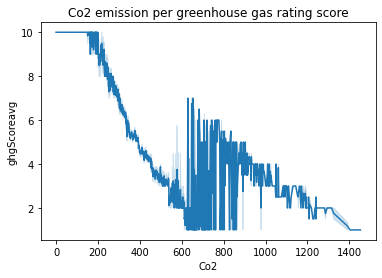

In [96]:
sns.lineplot(data=df, x="Co2", y="ghgScoreavg")

plt.title('Co2 emission per greenhouse gas rating score')


Text(0.5, 1.0, 'Co2 emission per cylinders')

<Figure size 2160x2160 with 0 Axes>

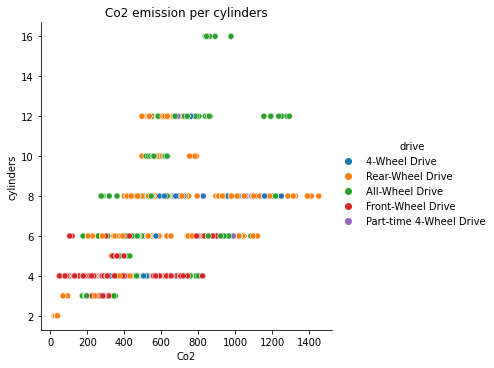

In [97]:
#from this graph we can see that as the number of cylinder increases the co2 emissions are also increasing 
#the type of drive is also influencing thsns.lineplot(data=flights, x="year", y="passengers", hue="month")e emissions 
plt.figure(figsize=(30,30))
sns.relplot(data=df, x="Co2", y="cylinders", hue='drive')

plt.title('Co2 emission per cylinders')

/var/folders/x7/tm9d29mx1lv2zl6slvnz5xvw0000gn/T/ipykernel_17497/2902534495.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


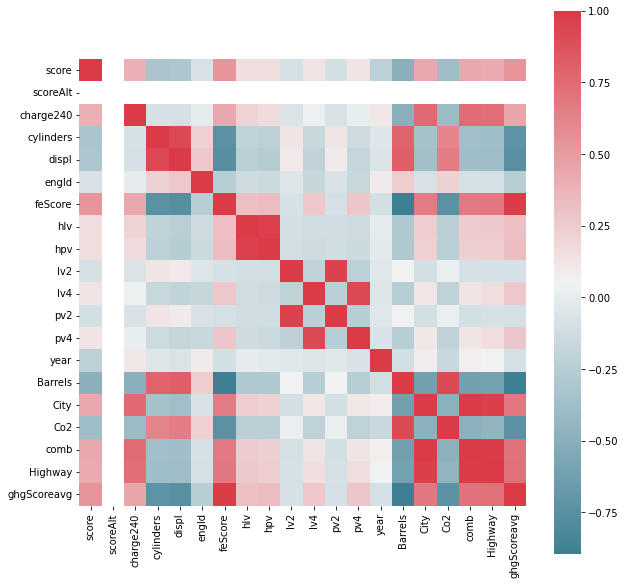

In [69]:
plt.figure(figsize=(10,10))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
plt.show()

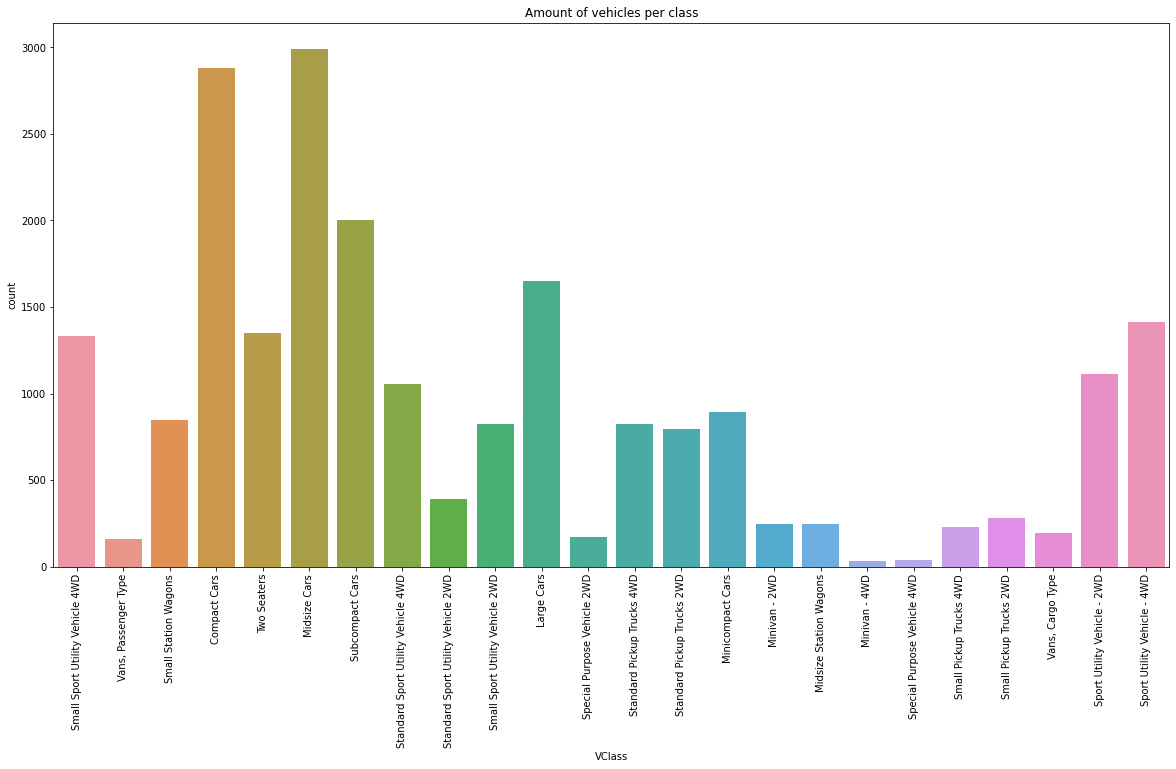

In [98]:
plt.figure(figsize=(20,10))
sns.countplot(data = df_raw, x = "VClass")
plt.xticks(rotation=90)
plt.title('Amount of vehicles per class')
plt.show()

In [71]:
Score_1_df = df.loc[df["ghgScoreavg"] == 1]

In [72]:
df.columns

Index(['score', 'scoreAlt', 'standard', 'stdText', 'charge240', 'cylinders',
       'displ', 'drive', 'engId', 'eng_dscr', 'feScore', 'fuelType', 'hlv',
       'hpv', 'lv2', 'lv4', 'make', 'model', 'pv2', 'pv4', 'trany', 'VClass',
       'year', 'trans_dscr', 'atvType', 'startStop', 'Barrels', 'City', 'Co2',
       'comb', 'Highway', 'Charger', 'ghgScoreavg'],
      dtype='object')

In [74]:
Score_10_df = df.loc[df["ghgScoreavg"] == 10]

Text(0.5, 1.0, 'Amount of vehicles per cylinders in GHG SCORE 1')

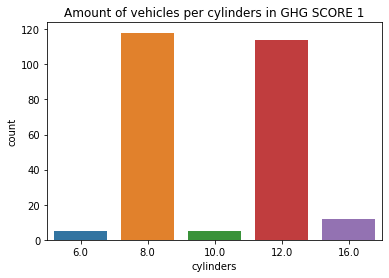

In [99]:
# Most of the veichle with a score of 10 have 8.0 cylinders or 12.0 cylinders 
sns.countplot(x = "cylinders", data = Score_1_df )

plt.title('Amount of vehicles per cylinders in GHG SCORE 1')

Text(0.5, 1.0, 'Amount of vehicles per cylinders in GHG SCORE 10')

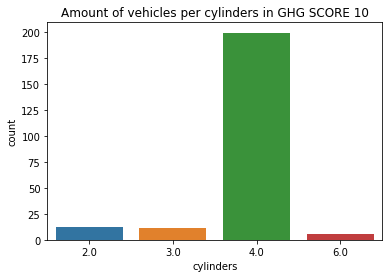

In [100]:
# Most of the veichle with a score of 10 has 4.0 cylinders 
sns.countplot(x = "cylinders", data = Score_10_df )

plt.title('Amount of vehicles per cylinders in GHG SCORE 10')

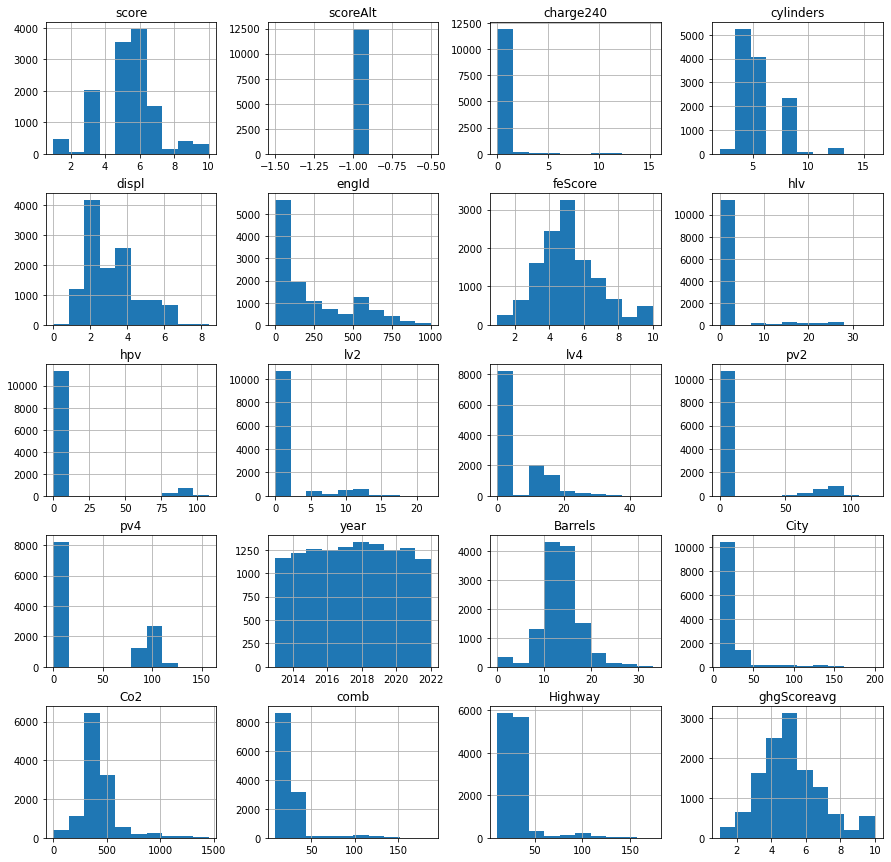

In [81]:
df.hist(figsize=(15,15))
plt.show()

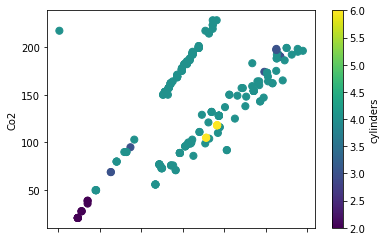

In [76]:
# The veichle with score 10 have a range between 2.0 and 6.0 cylindric  
Score_10_df.plot.scatter(x="Barrels", y="Co2", c = "cylinders", cmap="viridis", s=50);

<AxesSubplot:xlabel='Barrels', ylabel='Co2'>

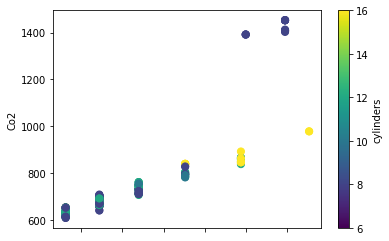

In [77]:
Score_1_df.plot.scatter(x="Barrels", y="Co2", c = "cylinders", cmap="viridis", s=50)



Text(0, 0.5, 'Annual petroleum consuption')

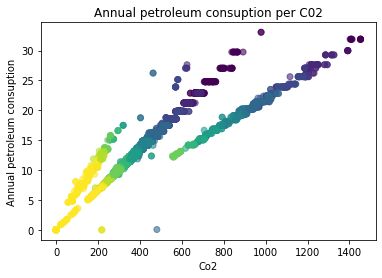

In [95]:
import matplotlib.pyplot as plt
plt.scatter(df.Co2, df.Barrels, c=df.ghgScoreavg, alpha = 0.6)

plt.title('Annual petroleum consuption per C02')
plt.xlabel('Co2')
plt.ylabel('Annual petroleum consuption')

Text(0, 0.5, 'City gasoline consuption')

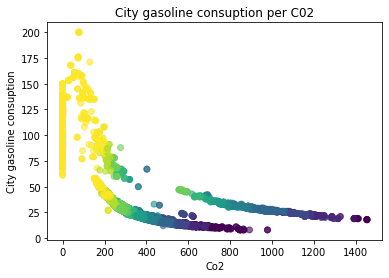

In [94]:

plt.scatter(df.Co2, df.City, c=df.ghgScoreavg, alpha = 0.6,)

plt.title('City gasoline consuption per C02')
plt.xlabel('Co2')
plt.ylabel('City gasoline consuption')

Text(0, 0.5, 'Highway gasoline consuption')

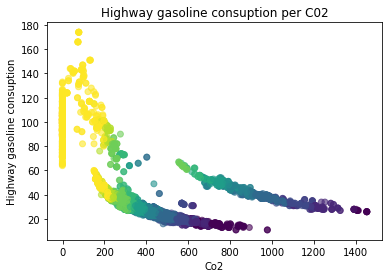

In [93]:
plt.scatter(df.Co2, df.Highway, c=df.ghgScoreavg, alpha = 0.6)

plt.title('Highway gasoline consuption per C02')
plt.xlabel('Co2')
plt.ylabel('Highway gasoline consuption')

In [118]:
df["make"].value_counts()

BMW                      1025
Ford                      896
Chevrolet                 862
Mercedes-Benz             800
Porsche                   664
Toyota                    598
GMC                       494
Audi                      448
Nissan                    437
Hyundai                   419
Kia                       396
Honda                     353
Jeep                      350
MINI                      347
Lexus                     331
Volkswagen                330
Cadillac                  282
Dodge                     274
Jaguar                    261
Mazda                     232
Infiniti                  230
Subaru                    224
Volvo                     214
Lincoln                   201
Land Rover                171
Mitsubishi                159
Buick                     153
Acura                     145
Ram                       124
Tesla                     119
Ferrari                   104
Chrysler                   97
Maserati                   88
Genesis   

### Transform the categorical features into Numerical

We are going to transform the categorical features (object) into numericalwith the function 'proc_df'.
It takes a data frame df and splits off the response variable, and changes the df into an entirely numeric dataframe. 

df: The data frame you wish to process
y: The name of the response variable
nas: returns a dictionary of which nas it created, and the associated median.

In [ ]:
df.dtypes

In [ ]:
df_backup = copy.deepcopy(df)

In [ ]:
train_cats(df)

In [ ]:
df.fuelType.cat.categories.tolist()

In [ ]:
df.fuelType.cat.categories

In [ ]:
df.fuelType.cat.codes

In [ ]:
#those will be the classes we are going to predict in the classification model 

df['ghgScoreavg'].value_counts()

In [ ]:
df, y, nas = proc_df(df, y_fld='ghgScoreavg')

In [ ]:
df

In [ ]:
df.dtypes

In order to apply a classification model we need to transform the ghgScore variable from float into integer. 

In [ ]:
y = [int(val) for val in y]
y

In [ ]:
y.count(2.5)

In [ ]:
#now all the variables are transformed into numerical 
df.dtypes

In [ ]:
print(df.shape)

# Classification 

The variable we want to predict is the ghgScore, which is categorical and have 10 possible outputs, therefore it is a multi-class classification. 


Popular algorithms that can be used for multi-class classification include:<br>
k-Nearest Neighbors <br>
Decision Trees.<br>
Naive Bayes.<br>
Random Forest.<br>
Gradient Boosting.

We are going to use the random forest classifier. 

In [ ]:
x = df
y

We split X and y into train (80%) and test (20%) and then X_train and Y_train into train (80%) and validation (20%).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,\
                                    test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test,\
                                    test_size=0.2, random_state=42)

In [ ]:
x_train.shape, len(y_train), x_test.shape, len(y_test), x_val.shape, len(y_val)

## Decision Tree Classifier

In [ ]:
tree_classifier = DecisionTreeClassifier(
    class_weight = None, # specific to classifiers
    criterion = 'gini',  # specific to classifiers
    splitter = 'best', 
    max_depth = None, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = None, 
)

In [ ]:
%time tree_classifier.fit(x_train, y_train)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 15), dpi = 400)
plot_tree(tree_classifier, filled = True)

Check the accuracy of the decision tree classifier.

The accuracy is the percentage of well-predicted classes among an evaluation dataset, although it could be a missleading metric if we have an imblanced dataset.


In [ ]:
print(tree_classifier.score(x_train, y_train)) 
print(tree_classifier.score(x_val, y_val))

## Random Forest Classifier

To solve the imbalance problem we are going to run a random forest classifier algorithm, which is creating a several decision tress (like the n_estimators), it gets a prediction from each tree and it selects the best model between those. 

One of the differences between a Random Forest Classifier and a Random Forest Regressor it the class_weight parameter.
The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 

In [ ]:
#random forest classifier with default parameters 

rfc = RandomForestClassifier(
    n_estimators=100, #The number of trees in the forest
    criterion='gini', #The function to measure the quality of a split
    max_depth=None, #The minimum number of samples required to split an internal node
    min_samples_split=2, #The minimum number of samples required to be at a leaf node
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, #Whether to use out-of-bag samples to estimate the generalization score.
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [ ]:
%time rfc.fit(x_train, y_train)


print(rfc.score(x_train, y_train)) # classification accuracy on training set
print(rfc.score(x_val, y_val)) # classification accuracy on validation set

### The metrics 

Precision is the number of correctly-identified members of a class divided by all the times the model predicted that class.

Recall is the number of members of a class that the classifier identified correctly divided by the total number of members in that class.

F1 score is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too.

In [ ]:
y_pred = rfc.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred, average = 'micro')
prc = metrics.precision_score(y_test, y_pred, average = 'micro')
f1  = metrics.f1_score(y_test, y_pred, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
print(classification_report(y_test, y_pred))

### Hyperparmeter tuning 
Here we are defining as a dictionary which parameters we want to test. 

In [ ]:
rfc.get_params()

In [ ]:
param_grid = { 
    #'n_estimators': list(range(100, 500)), #= 1000
    #'criterion': ['gini','entropy'], #= entropy
    #'max_depth': list(range(2, 40)), #= 16 
    #'max_depth': list(range(2, 40)), #= 22
    #'min_samples_leaf': list(range(1,20)),#=1
    #'oob_score': [True, False], #= True
    #'class_weight': ['balanced', 'balanced_subsample', 'None'] #balanced
}

In [ ]:
CVclassifier = GridSearchCV(estimator=rfc, 
                            param_grid=param_grid, 
                            cv= 5 #Determines the cross-validation splitting strategy.
                           )
CVclassifier.fit(x_train, y_train)

In [ ]:
CVclassifier.fit(x_train, y_train)

In [ ]:
para = CVclassifier.best_params_
para

### After hyperparameters tuning 

It is natural that random forest will stabilize after some n_estimators(because there is no mechnisum to "slow down" the fitting unlike boosting). Since there is no benefit to adding more weak tree estimators, we chose 200. 

In [ ]:
#we the best parameters after the hypertuning

rfc_tuned = RandomForestClassifier(
    n_estimators=200, 
    criterion='entropy', 
    max_depth=22, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight='balanced',
    ccp_alpha=0.0, 
    max_samples=None
)

In [ ]:
%time rfc_tuned.fit(x_train, y_train)

print(rfc.score(x_train, y_train)) # classification accuracy on training set
print(rfc.score(x_val, y_val)) # classification accuracy on validation set

In [ ]:
y_pred = rfc.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred, average = 'micro')
prc = metrics.precision_score(y_test, y_pred, average = 'micro')
#spe = specificity_score(y_test, y_predict_valid)
f1  = metrics.f1_score(y_test, y_pred, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
#print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

In [ ]:
print(classification_report(y_test, y_pred))

### Model calibration 

A classifier can be calibrated in scikit-learn using the CalibratedClassifierCV class.

There are two ways to use this class: prefit and cross-validation.

You can fit a model on a training dataset and calibrate this prefit model using a hold out validation dataset.

In [ ]:
rfc_calibrated = CalibratedClassifierCV(
    base_estimator = rfc_tuned,
    method = 'sigmoid', # 'sigmoid' or 'isotonic'
    ensemble = True,
    cv = 5, # int of 'prefit'
    n_jobs = -1,
)

In [ ]:
%time rfc_calibrated.fit(x_train, y_train)

print(rfc_calibrated.score(x_train, y_train)) 
print(rfc_calibrated.score(x_val, y_val))

In [ ]:
y_pred = rfc_calibrated.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred, average = 'micro')
prc = metrics.precision_score(y_test, y_pred, average = 'micro')
#spe = specificity_score(y_test, y_predict_valid)
f1  = metrics.f1_score(y_test, y_pred, average = 'micro')

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
#print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

conclusioni del prof 

Conclusion : The model has a tendency to over-estimate the price of a Buldozer, since buldozers that are predicted as high-priced will be so for only 70.77 % of them (the precision is 70.77%). The model is on the other hand able to recognize high-priced buldozers since 88.58% of expensive buldozers were predicted so by the model (the recall is 88.58%).
    
Accuracy : 79.92%
Recall : 88.58%
Precision : 70.77%
Specificity : 73.70%
F1-score : 78.68%

## Prediction attempt 

In [ ]:
print(y_pred)

In [ ]:
# first tree prediction on single data point
ranfor = rfc_tuned.estimators_[1] 
point = [x_val.iloc[1, :]]     
pred = ranfor.predict(point)      

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', (pred[0]))

In [ ]:
y[1]

## Features importance
In order to verify how the model is making predictions we can use feature_importance. 

Scikit-learn's implementation of Random Forests carry impurity-based feature importance scores (the higher, the more important the feature) in the attribute model.feature_importances_ of a fitted model. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature on the training set.

Since they are computed on the training set these scores should be taken with caution, as the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit. As a result, features that are deemed of low importance for a bad model (high training score but low validation/cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a validation set (or better with cross-validation) prior to computing importances. These feature importance does not reflect to the intrinsic predictive value of a feature by itself, but how important this feature is for a particular random forest.

In [ ]:
rfc_tuned = RandomForestClassifier(
    n_estimators=200, 
    criterion='entropy', 
    max_depth=22, 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=True, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)

In [ ]:
%time rfc_tuned.fit(x_train, y_train)

In [ ]:
feature_scores = pd.Series(rfc_tuned.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores

In [ ]:
#fare grafico delle features 
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)


# Final model export 

In [102]:
path_to_saves = os.path.join(path_to_repo, 'saves')
print(path_to_saves)

if not os.path.isdir(path_to_saves):
    os.mkdir(path_to_saves)
    print(path_to_saves, 'was created')
else:
    print(path_to_saves, 'already exists')

/Users/filippoceccarani/Desktop/EMLyon-ML-course-2022-T1/saves
/Users/filippoceccarani/Desktop/EMLyon-ML-course-2022-T1/saves already exists


In [ ]:
# save model on disk
path_to_model = os.path.join(path_to_repo, 'saves', 'RF_classifier.pk')
with open(path_to_model, 'wb') as file:
    dill.dump(rfc_tuned, file) 